In [324]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.linalg import block_diag

import random
from itertools import combinations
from math import floor

### Читаем список ребер из входных файлов

In [175]:
X_edges = pd.read_csv('Zig-Zag-algorithm/input/X_edges.txt', sep=',', header=None)
Y_edges = pd.read_csv('Zig-Zag-algorithm/input/Y_edges.txt', sep=',', header=None)

In [176]:
X_edges

,0,1
0,a,b
1,a,c
2,a,d
3,b,c
4,b,d
5,c,d


In [177]:
Y_edges

,0,1
0,1,2
1,1,3
2,2,3


### Создаем графы X, Y из соответствующих таблиц ребер

In [178]:
X = nx.from_pandas_edgelist(X_edges, *X_edges.columns, create_using=nx.Graph())
Y = nx.from_pandas_edgelist(Y_edges, *Y_edges.columns, create_using=nx.Graph())

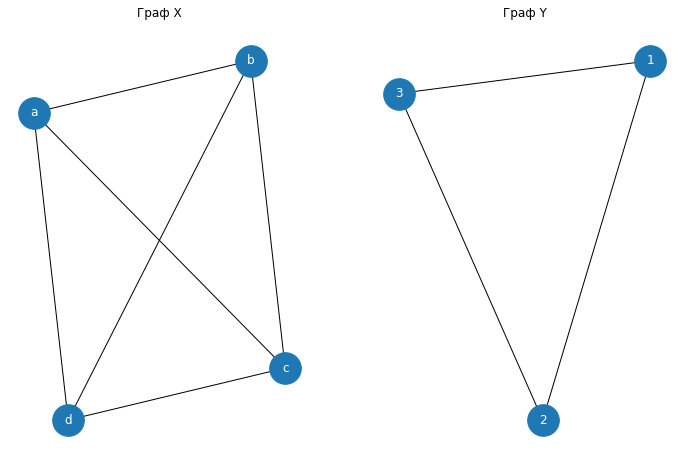

In [6]:
fig, ax = plt.subplots(1,2, figsize = (12,8))

nx.draw(X, ax=ax[0], node_size=1000, font_color='white', with_labels=True)
ax[0].title.set_text('Граф X')

nx.draw(Y, ax=ax[1], node_size=1000, font_color='white', with_labels=True)
ax[1].title.set_text('Граф Y')

### <font color='red'>To Do</font> 
`Проверка на регулярность и размерность входных графов`

## Алгоритм зиг-заг (из книги "Expander Families and Cayley Graphs"):

### Шаг 1: создаем блочно-диагональную матрицу G размера $|X|\cdot|Y|\times|X|\cdot|Y|$ . Блоки матрицы - это матрицы смежности графа Y

In [7]:
G_np_arr = block_diag(*(X.number_of_nodes() * [nx.to_numpy_array(Y)]))
G_np_arr

array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.]])

### Переводим матрицу смежности в граф и присваиваем соответствующие названия вершин

In [8]:
G = nx.from_numpy_array(G_np_arr)

XY = nx.cartesian_product(X, Y)
XY.nodes

NodeView((('a', 1), ('a', 2), ('a', 3), ('b', 1), ('b', 2), ('b', 3), ('c', 1), ('c', 2), ('c', 3), ('d', 1), ('d', 2), ('d', 3)))

In [9]:
mapping = {old_label:new_label for old_label, new_label in enumerate(list(XY.nodes))}
G = nx.relabel_nodes(G, mapping)

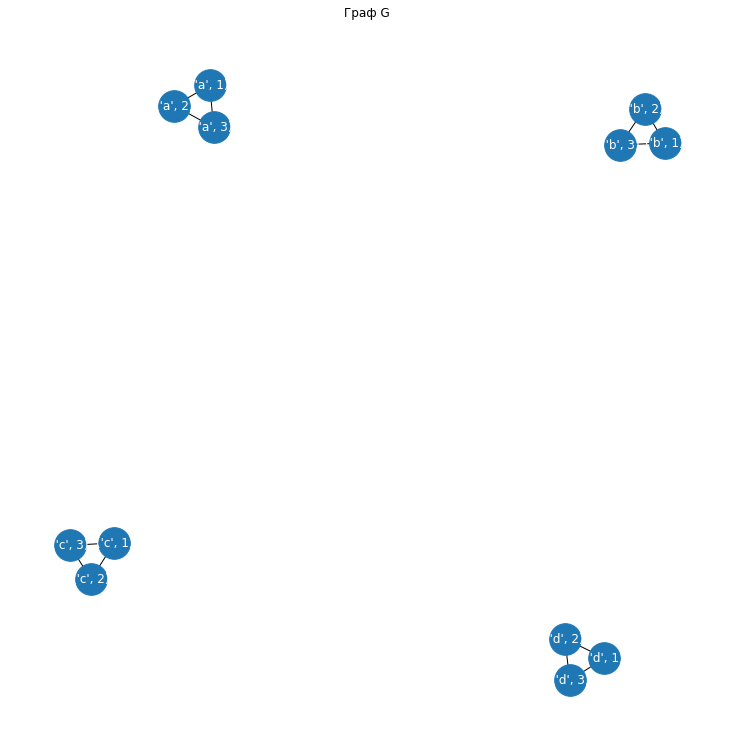

In [12]:
plt.figure(1,figsize=(10,10)) 
nx.draw(G, node_size=1000, font_color='white', with_labels=True) 
plt.title('Граф G');

### Шаг 2: Генерируем рандомный лэйблинг вокруг каждой вершины из графа Х. Создаем таблицу для лэйблинга: вход - $(x_i, y_k)$ выход - $(x_i, x_j)$, где $x_i$ смежна с $x_j$

In [13]:
num_of_nodes_Y = Y.number_of_nodes()

labeling = list()
for n, nbrs in X.adj.items():
    node_labeling = random.sample(list(Y.nodes), num_of_nodes_Y)
    labels = list(zip([n] * num_of_nodes_Y, node_labeling))
    edges = list(zip([n] * num_of_nodes_Y, list(nbrs)))
    labeling.extend(list(zip(labels, edges)))    

In [14]:
labeling

[(('a', 2), ('a', 'b')),
 (('a', 1), ('a', 'c')),
 (('a', 3), ('a', 'd')),
 (('b', 2), ('b', 'a')),
 (('b', 1), ('b', 'c')),
 (('b', 3), ('b', 'd')),
 (('c', 1), ('c', 'a')),
 (('c', 2), ('c', 'b')),
 (('c', 3), ('c', 'd')),
 (('d', 3), ('d', 'a')),
 (('d', 1), ('d', 'b')),
 (('d', 2), ('d', 'c'))]

### Аггрегируем таблицу лэйблинга по ребрам и получаем таблицу смежных вершин

In [15]:
df = pd.DataFrame(labeling)
df[1] = [tuple(sorted(x)) for x in df[1]]
grouped_df = df.groupby(1)[0].agg(list)

grouped_df

1
(a, b)    [(a, 2), (b, 2)]
(a, c)    [(a, 1), (c, 1)]
(a, d)    [(a, 3), (d, 3)]
(b, c)    [(b, 1), (c, 2)]
(b, d)    [(b, 3), (d, 1)]
(c, d)    [(c, 3), (d, 2)]
Name: 0, dtype: object

### Создаем граф H на основе саггрегированной таблицы и декартового произведения вершин графов X, Y

In [16]:
H = nx.Graph()
H.add_nodes_from(XY.nodes)
H.add_edges_from(grouped_df.values)

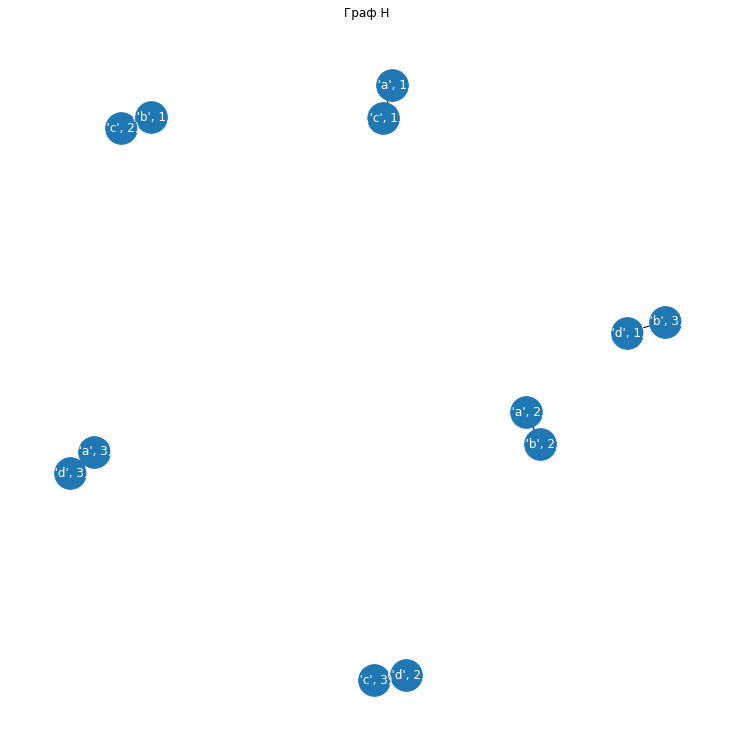

In [18]:
plt.figure(1,figsize=(10,10)) 
nx.draw(H, node_size=1000, font_color='white', with_labels=True)
plt.title('Граф H');

### Переводим граф H в матрицу смежности

In [19]:
H_np_arr = nx.to_numpy_array(H)

### Шаг 3: Получаем зиг-заг произведения путем перемножения матриц смежностей: $G\cdot H\cdot G$ 

In [20]:
zig_zag_np_arr = G_np_arr @ H_np_arr @ G_np_arr

In [21]:
zig_zag = nx.from_numpy_array(zig_zag_np_arr)

In [22]:
mapping = {old_label:new_label for old_label, new_label in enumerate(list(XY.nodes))}
zig_zag = nx.relabel_nodes(zig_zag, mapping)

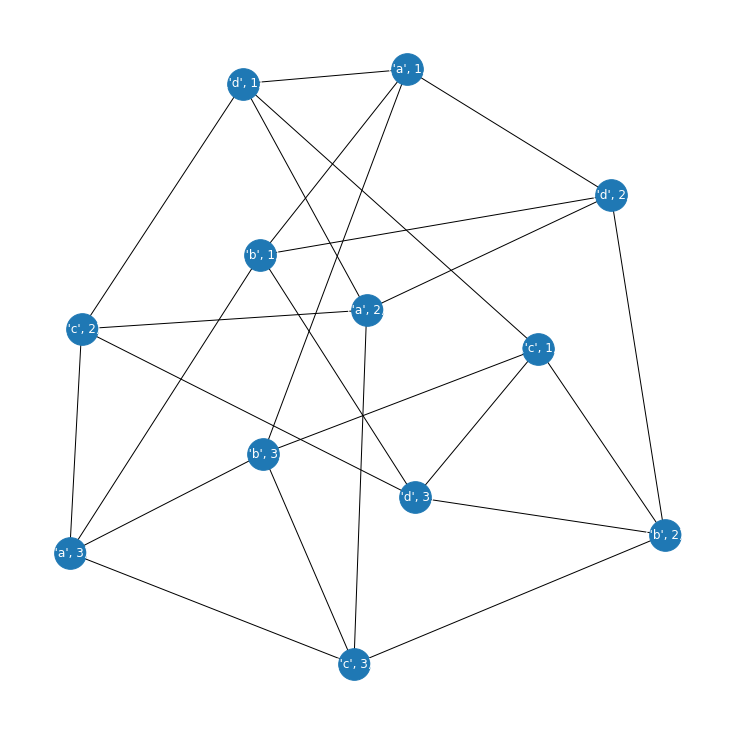

In [25]:
plt.figure(3,figsize=(10,10)) 
nx.draw(zig_zag, node_size=1000, font_color='white', with_labels=True)

### Пример 5.13 из книги (с. 125)

In [26]:
labeling = [
    (('a', 2), ('a', 'b')),
    (('a', 1), ('a', 'c')),
    (('a', 3), ('a', 'd')),
    (('b', 3), ('b', 'a')),
    (('b', 1), ('b', 'c')),
    (('b', 2), ('b', 'd')),
    (('c', 3), ('c', 'a')),
    (('c', 1), ('c', 'b')),
    (('c', 2), ('c', 'd')),
    (('d', 2), ('d', 'a')),
    (('d', 1), ('d', 'b')),
    (('d', 3), ('d', 'c'))
    ]

In [27]:
df = pd.DataFrame(labeling)
df[1] = [tuple(sorted(x)) for x in df[1]]
grouped_df = df.groupby(1)[0].agg(list)

grouped_df

1
(a, b)    [(a, 2), (b, 3)]
(a, c)    [(a, 1), (c, 3)]
(a, d)    [(a, 3), (d, 2)]
(b, c)    [(b, 1), (c, 1)]
(b, d)    [(b, 2), (d, 1)]
(c, d)    [(c, 2), (d, 3)]
Name: 0, dtype: object

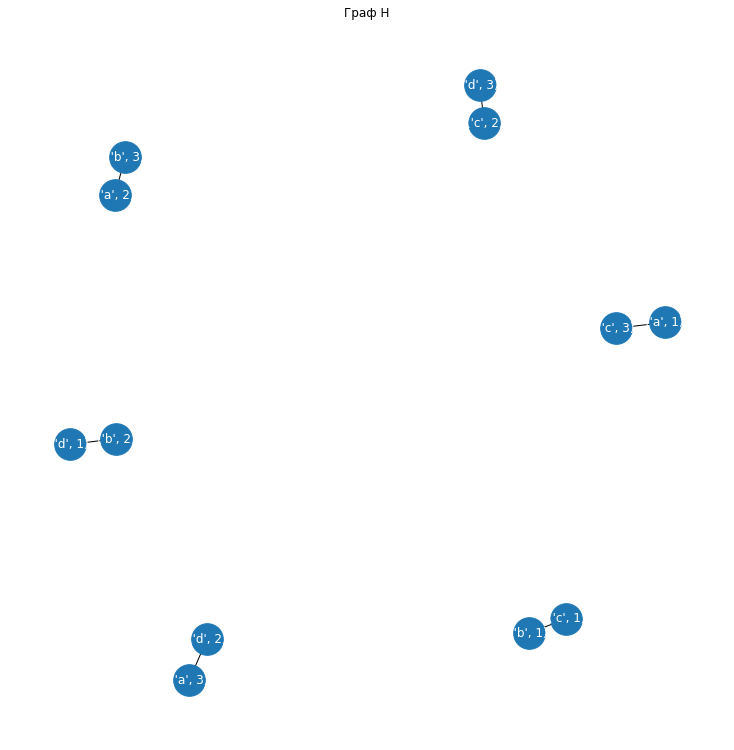

In [28]:
H = nx.Graph()
H.add_nodes_from(XY.nodes)
H.add_edges_from(grouped_df.values)

plt.figure(1,figsize=(10,10)) 
nx.draw(H, node_size=1000, font_color='white', with_labels=True)
plt.title('Граф H');

In [29]:
H_np_arr = nx.to_numpy_array(H)

zig_zag_np_arr = G_np_arr @ H_np_arr @ G_np_arr
zig_zag = nx.from_numpy_array(zig_zag_np_arr)

mapping = {old_label:new_label for old_label, new_label in enumerate(list(XY.nodes))}
zig_zag = nx.relabel_nodes(zig_zag, mapping)

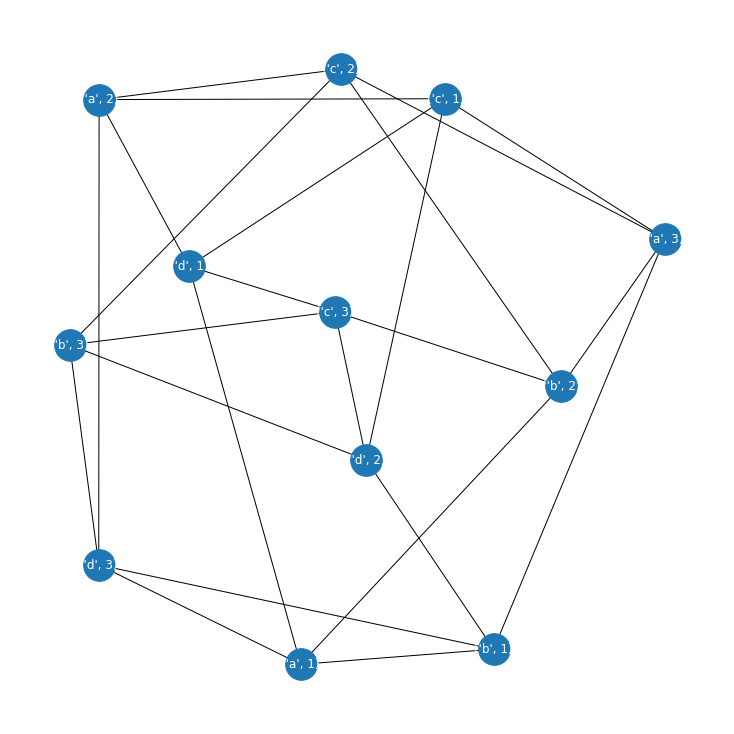

In [56]:
plt.figure(1,figsize=(10,10)) 
nx.draw(zig_zag, node_size=1000, font_color='white', with_labels=True)

### Спектральный пробел

#### Матрица Лапласа: $L = D - A$

In [379]:
print(nx.laplacian_matrix(zig_zag).toarray())

[[ 4.  0.  0. -1. -1.  0.  0.  0.  0. -1.  0. -1.]
 [ 0.  4.  0.  0.  0.  0. -1. -1.  0. -1.  0. -1.]
 [ 0.  0.  4. -1. -1.  0. -1. -1.  0.  0.  0.  0.]
 [-1.  0. -1.  4.  0.  0.  0.  0.  0.  0. -1. -1.]
 [-1.  0. -1.  0.  4.  0.  0. -1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  4.  0. -1. -1.  0. -1. -1.]
 [ 0. -1. -1.  0.  0.  0.  4.  0.  0. -1. -1.  0.]
 [ 0. -1. -1.  0. -1. -1.  0.  4.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1. -1.  0.  0.  4. -1. -1.  0.]
 [-1. -1.  0.  0.  0.  0. -1.  0. -1.  4.  0.  0.]
 [ 0.  0.  0. -1.  0. -1. -1.  0. -1.  0.  4.  0.]
 [-1. -1.  0. -1.  0. -1.  0.  0.  0.  0.  0.  4.]]


In [384]:
nx.algebraic_connectivity(zig_zag)

2.4384471871911715

#### Нормализованная матрица Лапласа: $N = D^{-1/2}LD^{-1/2}$

In [381]:
print(nx.normalized_laplacian_matrix(zig_zag).toarray())

[[ 1.    0.    0.   -0.25 -0.25  0.    0.    0.    0.   -0.25  0.   -0.25]
 [ 0.    1.    0.    0.    0.    0.   -0.25 -0.25  0.   -0.25  0.   -0.25]
 [ 0.    0.    1.   -0.25 -0.25  0.   -0.25 -0.25  0.    0.    0.    0.  ]
 [-0.25  0.   -0.25  1.    0.    0.    0.    0.    0.    0.   -0.25 -0.25]
 [-0.25  0.   -0.25  0.    1.    0.    0.   -0.25 -0.25  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.   -0.25 -0.25  0.   -0.25 -0.25]
 [ 0.   -0.25 -0.25  0.    0.    0.    1.    0.    0.   -0.25 -0.25  0.  ]
 [ 0.   -0.25 -0.25  0.   -0.25 -0.25  0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.25 -0.25  0.    0.    1.   -0.25 -0.25  0.  ]
 [-0.25 -0.25  0.    0.    0.    0.   -0.25  0.   -0.25  1.    0.    0.  ]
 [ 0.    0.    0.   -0.25  0.   -0.25 -0.25  0.   -0.25  0.    1.    0.  ]
 [-0.25 -0.25  0.   -0.25  0.   -0.25  0.    0.    0.    0.    0.    1.  ]]


In [383]:
lambd = nx.algebraic_connectivity(zig_zag, normalized=True)
lambd

0.609611796797793

## Алгоритм вычисления изопериметрической константы

### Создаем подмножества $S \subset V$, $|S|\leq \frac{|V|}{2}$

In [272]:
def create_subsets_from(set_of_nodes):
    subsets = set(combinations(set_of_nodes, 1))
    
    for i in range(1, floor(len(set_of_nodes) / 2)):
        subsets = subsets.union(set(combinations(set_of_nodes, i + 1)))    
        
    return subsets

In [273]:
set_of_nodes_X = set(X.nodes)
subsets_X = create_subsets_from(set_of_nodes_X)

In [274]:
for subset in subsets_X:
    print(subset)

('c', 'd')
('b', 'a')
('a',)
('b', 'd')
('c',)
('b',)
('d',)
('a', 'd')
('c', 'b')
('c', 'a')


In [275]:
def adjacency_table(graph):
    adjacency_table = dict()
    for n, nbrs in graph.adj.items():
        adjacency_table[n] = set(nbrs)
        
    return adjacency_table

In [276]:
adjacency_table_X = adjacency_table(X)
adjacency_table_X

{'a': {'b', 'c', 'd'},
 'b': {'a', 'c', 'd'},
 'c': {'a', 'b', 'd'},
 'd': {'a', 'b', 'c'}}

### Вычисление изопериметрической константы путем перебора каждого подмножества $S$

In [362]:
def calculate_isoperimetric(subsets, adjacency_table):
    isoperimetric_num = np.inf

    for subset in subsets:
        edge_bound = list()
        for i in subset:
            edge_bound.extend(list(adjacency_table[i].difference(subset)))
    
        isoperimetric_num = min(isoperimetric_num, len(edge_bound) / len(subset))
        
    return isoperimetric_num

#### Для входного графа Х:

In [363]:
calculate_isoperimetric(subsets_X, adjacency_table_X)

2.0

#### Для входного графа Y:

In [364]:
set_of_nodes_Y = set(Y.nodes)
subsets_Y = create_subsets_from(set_of_nodes_Y)

In [365]:
adjacency_table_Y = adjacency_table(Y)

In [366]:
calculate_isoperimetric(subsets_Y, adjacency_table_Y)

2.0

#### Для графа, полученного зиг-заг произведением:

In [367]:
set_of_nodes_zig_zag = set(zig_zag.nodes)
subsets_zig_zag = create_subsets_from(set_of_nodes_zig_zag)

In [368]:
adjacency_table_zig_zag = adjacency_table(zig_zag)

In [369]:
calculate_isoperimetric(subsets_zig_zag, adjacency_table_zig_zag)

1.3333333333333333